**_This notebook gives a detailed overview of prediction algorithm to predict the number of bets that are made in the next hour._**
-  This prediction will be very useful for the company to assess the risks and perform server scaling if needed.
- If the bets for next hour is known beg´fore hand, then it is easy to promote and perform marketing campaigns.

In [0]:
pip install torch

In [0]:
dbutils.library.restartPython()

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import numpy as np

In [0]:
df = pd.read_csv('/Workspace/Users/deepak.guru.ganesan@volvo.com/leovegas/dataset_cleaned.csv').drop(['Unnamed: 0'], axis=1)

#### Target creation

**_The idea is to predict what is the number of bets that will be made in the next hour.I have created a column called next_hour_bet doing the merge operation as shown below._** 

In [0]:
df['bet_placement_hour'] = pd.to_datetime(df['bet_placement_hour'])
df["Next_hour"] = df["bet_placement_hour"] + pd.Timedelta(hours=1)

df = df.merge(df[["eventId", "bet_placement_hour", "number_of_bets","eventName"]],
    left_on=["eventId", "Next_hour","eventName"],
    right_on=["eventId", "bet_placement_hour","eventName"],
    suffixes=("", "_next"),
    how="left"
)
# Rename the target column
df.rename(columns={"number_of_bets_next": "Next_hour_bets"}, inplace=True)

# Drop the extra "Bet_placement_hour_next" column
df.drop(columns=["Next_hour", "bet_placement_hour_next"], inplace=True)
df["Next_hour_bets"].fillna(0, inplace=True)
print(len(df))

228954


#### Create new columns

_**We calculated the rolling average of number of bets for the last 7 days over the whole league, and the rolling sum of last 3 hours for the event**_ 

In [0]:
df = df.sort_values(by="bet_placement_hour")
sum_df = df.groupby(by=["eventId","bet_placement_hour"], as_index=False)["number_of_bets"].sum()

rolling_sum_series = (
    sum_df.groupby(["eventId"])
    .rolling(on="bet_placement_hour", window="3H", min_periods=1)
    .sum()
).reset_index().drop(['level_1'],axis=1).rename(columns={"number_of_bets": "rolling_bets_3h"})

mean_df = df.groupby(by=["league","bet_placement_hour"], as_index=False)["number_of_bets"].mean()

rolling_average_series = (
    mean_df.groupby(["league"])
    .rolling(on="bet_placement_hour", window="7D", min_periods=1)
    .mean()
).reset_index().drop(['level_1'],axis=1).rename(columns={"number_of_bets": "league_avg_bets_7d"})

df = pd.merge(df,rolling_sum_series, on=["eventId","bet_placement_hour"], how="left")
df = pd.merge(df,rolling_average_series, on=["league","bet_placement_hour"], how="left")


In [0]:
#Example display of target and new columns created
df[df.eventId==1022226974].sort_values(by="bet_placement_hour")

,eventId,bet_placement_hour,eventName,league,event_country,eventStartDate,number_of_bets,total_turn_over_EUR,Next_hour_bets,rolling_bets_3h,league_avg_bets_7d
228451,1022226974,2024-11-30 16:00:00,Pepperdine Waves - Weber State Wildcats,NCAAB,Unknown,2024-11-30 21:31:00,16,22.790747,4.0,16.0,31.997256
228580,1022226974,2024-11-30 17:00:00,Pepperdine Waves - Weber State Wildcats,NCAAB,Unknown,2024-11-30 21:31:00,4,3.133271,0.0,20.0,31.940280
228694,1022226974,2024-11-30 19:00:00,Pepperdine Waves - Weber State Wildcats,NCAAB,Unknown,2024-11-30 21:31:00,2,13.541527,69.0,6.0,31.700361
228802,1022226974,2024-11-30 20:00:00,Pepperdine Waves - Weber State Wildcats,NCAAB,Unknown,2024-11-30 21:31:00,69,90.534100,1.0,71.0,31.756458
228830,1022226974,2024-11-30 21:00:00,Pepperdine Waves - Weber State Wildcats,NCAAB,Unknown,2024-11-30 21:31:00,1,6.701053,63.0,72.0,31.590230
228878,1022226974,2024-11-30 22:00:00,Pepperdine Waves - Weber State Wildcats,NCAAB,Unknown,2024-11-30 21:31:00,63,499.192698,8.0,133.0,31.693520
228916,1022226974,2024-11-30 23:00:00,Pepperdine Waves - Weber State Wildcats,NCAAB,Unknown,2024-11-30 21:31:00,8,838.804358,0.0,72.0,31.834844


**_Creating other important columns_**

In [0]:
df["bet_hour"] = df["bet_placement_hour"].dt.hour  # 0-23
df["bet_dayofweek"] = df["bet_placement_hour"].dt.weekday  # 0=Monday, 6=Sunday
df["bet_weekend"] = (df["bet_dayofweek"] >= 5).astype(int)  # 1 if Saturday/Sunday, else 0
df["bet_month"] = df["bet_placement_hour"].dt.month  # 1-12
df["bet_year"] = df["bet_placement_hour"].dt.year  # 1-12
df["bet_day"] = df["bet_placement_hour"].dt.day  # 1-31

df["eventStartDate"] = pd.to_datetime(df['eventStartDate'])
df["time_until_event"] = (df["eventStartDate"] - df["bet_placement_hour"]).dt.total_seconds() / 3600  # Hours until event start
df["event_hour"] = df["eventStartDate"].dt.hour  # 0-23
df["event_dayofweek"] = df["eventStartDate"].dt.weekday  # 0=Monday, 6=Sunday
df["event_weekend"] = (df["event_dayofweek"] >= 5).astype(int)  # 1 if Saturday/Sunday, else 0
df["event_month"] = df["eventStartDate"].dt.month  # 1-12
df["event_year"] = df["eventStartDate"].dt.year  # 1-12
df["event_day"] = df["eventStartDate"].dt.day

df["league_popularity"] = df.groupby("league")["number_of_bets"].transform("sum") # Popularity of league (total bets in dataset)
df["team_popularity"] = df.groupby("eventName")["number_of_bets"].transform("sum") # Team popularity (if we can extract team names from eventName)

# Turnover per bet (average amount per bet)
df["avg_bet_size"] = df["total_turn_over_EUR"] / df["number_of_bets"]
# Is the event live? (Bet placed after event started)
df["is_live_bet"] = (df["bet_placement_hour"] >= df["eventStartDate"]).astype(int)

df.drop(columns=["bet_placement_hour", "eventStartDate"], inplace=True)

In [0]:
df.head()

,eventId,eventName,league,event_country,number_of_bets,total_turn_over_EUR,Next_hour_bets,rolling_bets_3h,league_avg_bets_7d,bet_hour,bet_dayofweek,bet_weekend,bet_month,bet_year,bet_day,time_until_event,event_hour,event_dayofweek,event_weekend,event_month,event_year,event_day,league_popularity,team_popularity,avg_bet_size,is_live_bet
0,1019538377,NCAAB Championship 2023/24,NCAAB,Unknown,17,76.444369,0.0,17.0,86.642857,0,4,0,12,2023,1,3114.000000,18,0,0,4,2024,8,1282587,5504,4.496728,0
1,1020030713,Toronto Raptors - New York Knicks,NBA,USA,10,5.862671,16.0,10.0,599.727273,0,4,0,12,2023,1,24.750000,0,5,1,12,2023,2,9945533,11170,0.586267,0
2,1020030714,Cleveland Cavaliers - Portland Trail Blazers,NBA,USA,1347,20520.485518,925.0,1347.0,599.727273,0,4,0,12,2023,1,0.250000,0,4,0,12,2023,1,9945533,2294,15.234213,0
3,1020030715,Minnesota Timberwolves - Utah Jazz,NBA,USA,210,5780.006393,532.0,210.0,599.727273,0,4,0,12,2023,1,1.250000,1,4,0,12,2023,1,9945533,786,27.523840,0
4,1020030716,Dallas Mavericks - Memphis Grizzlies,NBA,USA,17,0.815632,18.0,17.0,599.727273,0,4,0,12,2023,1,24.679722,0,5,1,12,2023,2,9945533,17806,0.047978,0


### Label Encoding

**_We are encoding all the categorical and string columns here before using them on the Machine learning models_**

In [0]:
# List of categorical columns
cat_columns = ["league", "event_country", "eventName"]

# Apply label encoding
label_encoders = {}  # Store encoders for future use
for col in cat_columns:
    le = LabelEncoder()
    df[col + "_encoded"] = le.fit_transform(df[col].astype(str))  # Ensure strings
    label_encoders[col] = le  # Save encoder for later (e.g., if using test data)

df.drop(["league", "event_country", "eventName"],axis= 1, inplace=True)
#df_test["League_encoded"] = label_encoders["League"].transform(df_test["League"].astype(str))

#### Feature Selection

**_Feature selection using correlation matrix is performed and based on the collinearity of the feature pairs, if any pair denotes a very high correlation for one another, we keep one and remove the other, thereby reducing dominance of certain features._** 

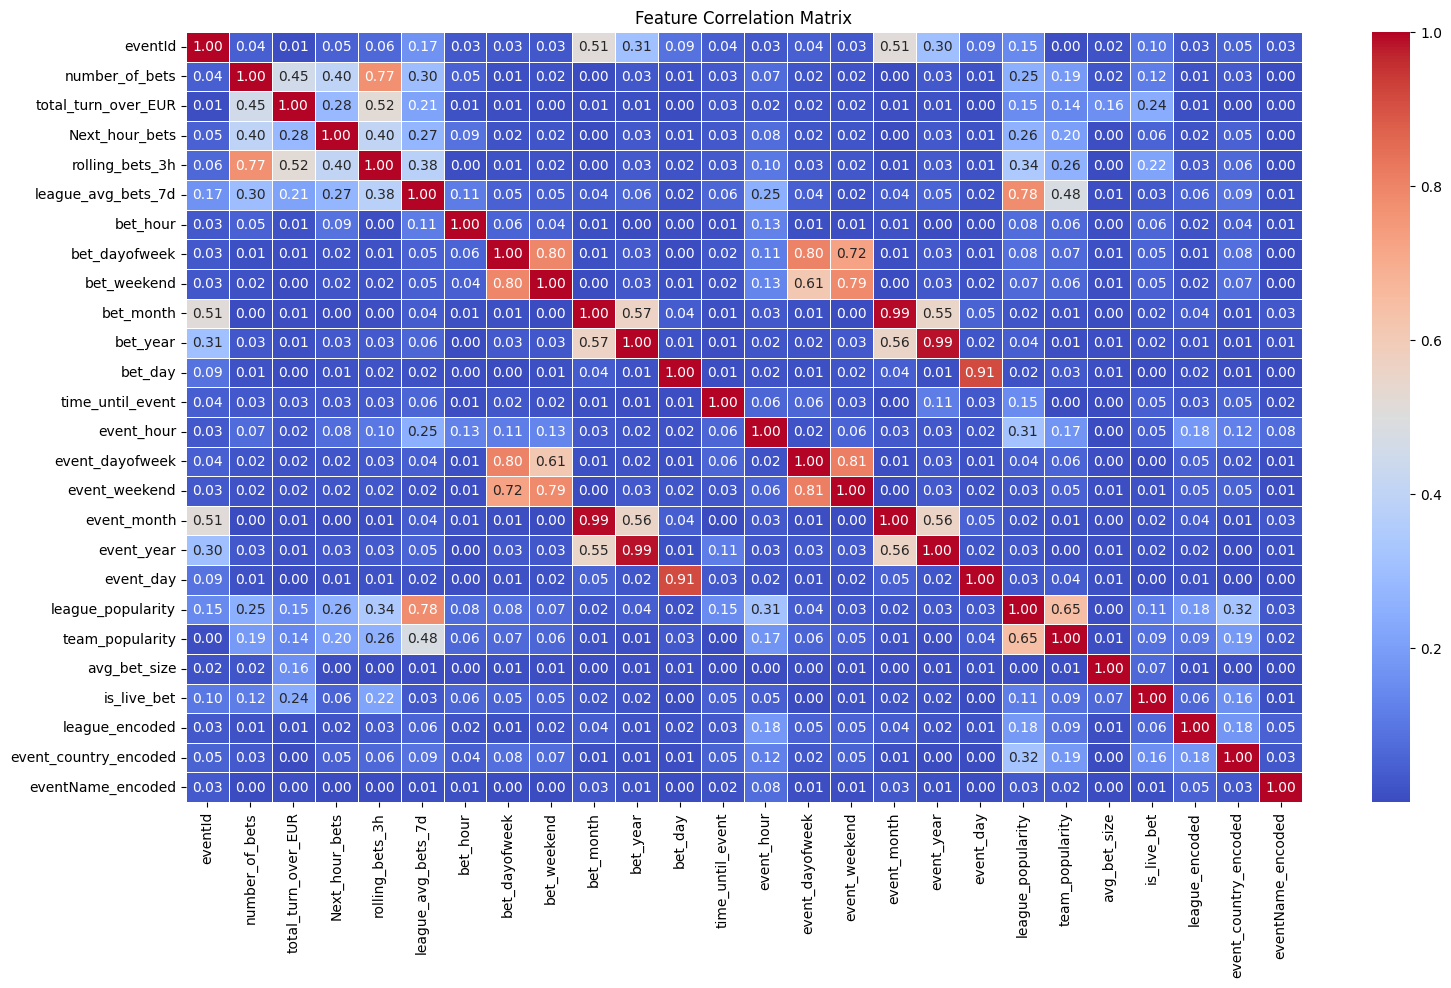

Dropped features due to high correlation: {'event_day', 'event_month', 'bet_year'}


In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr().abs()

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Select the upper triangle of the correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation > 0.9
to_drop = set()
for column in upper.columns:
    correlated_features = upper.index[upper[column] > 0.9].tolist()
    if correlated_features:
        # Keep one feature (the one with higher variance) and drop others
        keep = column  # Assume 'column' is the better feature to keep
        drop_candidates = correlated_features

        # Check variance to decide which one to drop
        if df[keep].std() < df[drop_candidates].std().max():
            keep = drop_candidates[np.argmax(df[drop_candidates].std())]  # Keep the one with max variance
            drop_candidates.append(column)  # Add original column to drop list

        to_drop.update(set(drop_candidates) - {keep})  # Drop all except 'keep'

#Drop selected features
df.drop(columns=to_drop, inplace=True)
print(f"Dropped features due to high correlation: {to_drop}")


#### Feature importance through Random Forest Regressor
**_Here we calculated feature importance just by fitting the model, and then check which features affect the accuracy of the model the most. Based on the comparison, the feature importance bar graph is generated._** 

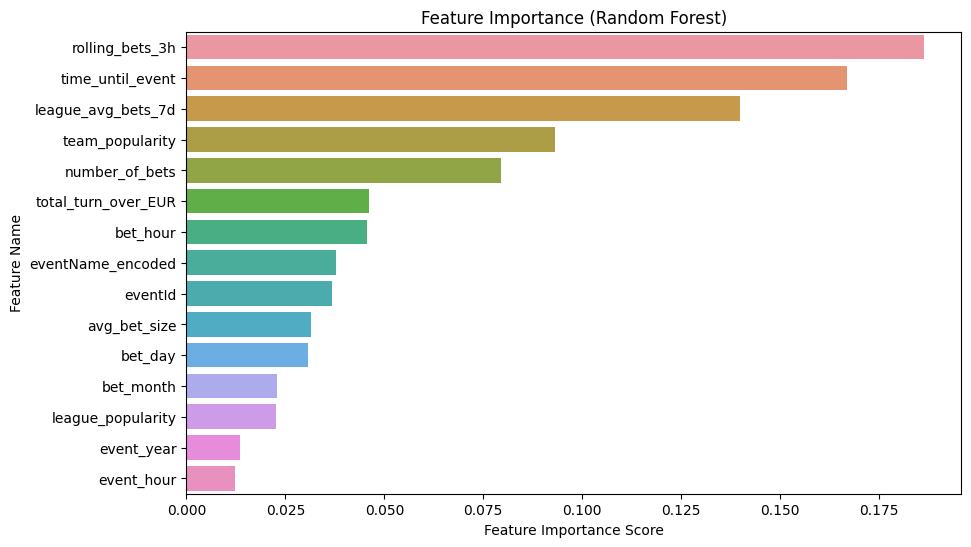

In [0]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Defining features (X) and target (y)
X = df.drop(columns=["Next_hour_bets"])  # Drop target column
X = X.astype(np.float64)
y = df["Next_hour_bets"]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance[:15], y=feature_importance.index[:15])  # Top 15 features
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [0]:
# Filtering features with importance >= 0.01
important_features = feature_importance[feature_importance >= 0.01].index

# Keeping only the important features in the dataset
df = df[important_features.tolist() + ['Next_hour_bets']]  # Include the target column too
print(f"Features kept: {important_features.tolist()}")

Features kept: ['rolling_bets_3h', 'time_until_event', 'league_avg_bets_7d', 'team_popularity', 'number_of_bets', 'total_turn_over_EUR', 'bet_hour', 'eventName_encoded', 'eventId', 'avg_bet_size', 'bet_day', 'bet_month', 'league_popularity', 'event_year', 'event_hour']


#### Prediction of Next Hour Bet through XG Boost Regression Model

In [0]:
import xgboost as xgb

# Define the features (X) and target (y)
X = df.drop(columns=["Next_hour_bets"])  # Features
y = df["Next_hour_bets"]  # Target

# Sort by time
#df = df.sort_values(by=["bet","bet_month",""])

# Use 80% of the earliest data for training, and the last 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,shuffle=True)



xgb_model = xgb.XGBRegressor(
    n_estimators=200,  # Number of trees
    learning_rate=0.01,  # Step size
    max_depth=10,  # Depth of trees
    subsample=0.8,  # Row sampling
    colsample_bytree=0.8,  # Feature sampling
    objective="reg:squarederror",  # Regression
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)
# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate performance using RMSE and R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAE: {mae}")

RMSE: 182.64537259137498
R²: 0.5706893711122296
MAE: 52.53219059740218


##### Ensemble Model

_**This is the code to perform ensembled regression using Voting regressor where both random forest and xgb regression models are tried and evaluated using many metrics as shown below**_

In [0]:
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
import catboost as cb

# Initialize individual models for the ensemble
xgb_model = xgb.XGBRegressor(n_estimators=30, random_state=42)
meta_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', max_iter=1000, random_state=42)


rf_model = RandomForestRegressor(max_depth=30, n_estimators=500, random_state=42)

ridge = Ridge(alpha=10.0)

model = cb.CatBoostRegressor(
    loss_function='RMSE',
    verbose=0,
    random_state=42,
    learning_rate=0.05,
    l2_leaf_reg=5,
    iterations=1000,
    depth=10
)


ensemble_model = VotingRegressor(
    estimators=[
        ('rf', rf_model),
        #('ridge', ridge),
       ('xgb', xgb_model)
    ])

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
y_pred = ensemble_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAE: {mae}")

results = pd.DataFrame({ 
    'Actual': y_test,
    'Predicted': y_pred
})
en_results = pd.concat([X_test, results], axis=1)
en_results['diff'] = en_results['Actual'] - en_results['Predicted']
en_results['diff'].describe()

RMSE: 176.22777113257024
R²: 0.6003286747663454
MAE: 55.345783247103384


count    45791.000000
mean        -2.628615
std        176.210090
min      -4119.208680
25%        -19.578604
50%         -4.658141
75%          2.418046
max      10424.471754
Name: diff, dtype: float64

#### **Neural Network Prediction through MLP (Multi Layer Perceptron)**

**_In each of the Method, many evaluation metrics are used to evaluate the predictions, like Root Mean Squared Error, Mean absolute error and R2 score. I have also shown the statistics around difference between the acutal value and predicted value (number_of_bets_next_hour)_**

In [0]:
X = df.drop(columns=["Next_hour_bets"])  # Features
y = df["Next_hour_bets"]  # Target

In [0]:
from sklearn.preprocessing import MinMaxScaler
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42, shuffle=True)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)  # Make y 2D
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)  # Make y 2D
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Create PyTorch DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Define MLP Model
class MLPRegressor(nn.Module):
    def __init__(self, input_size):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            #nn.ReLU(),
            nn.Dropout(0.2),  # Drop 20% of neurons
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.ReLU(),  # Ensures non-negative outputs
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
model = MLPRegressor(input_size=22).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            y_val_pred = model(X_val)
            val_loss += criterion(y_val_pred, y_val).item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss/len(val_loader):.4f}")

# Save model
# torch.save(model.state_dict(), "mlp_regression_model.pth")

# # Load model (optional)
# model.load_state_dict(torch.load("mlp_regression_model.pth"))
model.eval()

# Predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor).cpu().numpy().flatten()

# Convert tensors to NumPy arrays for evaluation
y_test_np = y_test_tensor.cpu().numpy().flatten()

# Evaluation Metrics
mae = mean_absolute_error(y_test_np, y_pred_tensor)
mse = mean_squared_error(y_test_np, y_pred_tensor)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_tensor)

# Print Metrics
print("\nModel Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

nn_results = pd.DataFrame({
    'Actual': y_test_np,
    'Predicted': y_pred_tensor
})
nn_results['diff'] = nn_results['Actual'] - nn_results['Predicted']
nn_results['diff'].describe()

Epoch [10/100]: Train Loss = 50820.6636, Val Loss = 69378.6605
Epoch [20/100]: Train Loss = 50338.5149, Val Loss = 68629.7096
Epoch [30/100]: Train Loss = 49846.8187, Val Loss = 67432.7605
Epoch [40/100]: Train Loss = 49738.6296, Val Loss = 67552.1079
Epoch [50/100]: Train Loss = 49727.9810, Val Loss = 65598.1313
Epoch [60/100]: Train Loss = 47897.0079, Val Loss = 58684.9520
Epoch [70/100]: Train Loss = 45633.7723, Val Loss = 46307.8904
Epoch [80/100]: Train Loss = 43440.7565, Val Loss = 49586.1574
Epoch [90/100]: Train Loss = 44885.1784, Val Loss = 57653.5709
Epoch [100/100]: Train Loss = 42978.0351, Val Loss = 39269.9507

Model Evaluation:
Mean Absolute Error (MAE): 61.8620
Mean Squared Error (MSE): 45309.9844
Root Mean Squared Error (RMSE): 212.8614
R-squared (R²): 0.5202


count    22896.000000
mean        29.267632
std        210.844345
min      -1365.349976
25%          0.000000
50%          4.000000
75%         25.000000
max      14805.177734
Name: diff, dtype: float64